<a href="https://colab.research.google.com/github/faisal-ba-systems/ML-course-documents/blob/main/EDA_Project_Cost_Estimation_Business_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns

In [2]:
!pip install -q gdown

# https://docs.google.com/spreadsheets/d/1-jtwuKuHLrblzrk6Aa0FXxUC1PcvTaO-rR4FTBtjXOQ/edit?usp=sharing

!gdown 1-jtwuKuHLrblzrk6Aa0FXxUC1PcvTaO-rR4FTBtjXOQ

Downloading...
From (original): https://drive.google.com/uc?id=1-jtwuKuHLrblzrk6Aa0FXxUC1PcvTaO-rR4FTBtjXOQ
From (redirected): https://docs.google.com/spreadsheets/d/1-jtwuKuHLrblzrk6Aa0FXxUC1PcvTaO-rR4FTBtjXOQ/export?format=xlsx
To: /content/Project Milestone wise log for 24 months 07082025.xlsx
4.64MB [00:00, 17.4MB/s]


In [3]:
excel_path ='/content/Project Milestone wise log for 24 months 07082025.xlsx'
sheet_milestone_resource = 'Milestone Details'
sheet_projects = 'Projects'
sheet_log_hour_against_issue = 'Log Details'
df_milestone_resource = pd.read_excel(excel_path, sheet_name=sheet_milestone_resource)
df_projects = pd.read_excel(excel_path, sheet_name=sheet_projects)
df_log_hour_issue = pd.read_excel(excel_path, sheet_name=sheet_log_hour_against_issue)

In [4]:
def report_data_types_uniques_check(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []

    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())

    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [41]:
# report_data_types_uniques_check(df_projects)
# report_data_types_uniques_check(df_milestone_resource)
# report_data_types_uniques_check(df_log_hour_issue)

### Analysis Dataset

In [6]:
batch_color_discrete_map={
                'complete': 'green',
                'ongoing': 'gold',
                'upcoming': 'lightgreen',
                 }

project_category_color_discrete_map={
                'Commercial': 'green',
                'Non-Commercial': 'blue',
                'Others': 'red'
              }



# Section 1 - Analysis Project Overview - Timeline: 2001 - 2025

### Clean & Preprocess

In [7]:
# Safe conversion: invalid dates like '0000-00-00' will become NaT
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')
# Calculate duration in days (NaT-safe)
df_projects['duration_days'] = (df_projects['end_dt'] - df_projects['start_dt']).dt.days
# Format as 'YYYY-MM-DD'
df_projects['start_dt'] = df_projects['start_dt'].dt.strftime('%Y-%m-%d')
df_projects['end_dt'] = df_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Fill missing amounts with 0 if necessary
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce').fillna(0)
# Check rows where date parsing failed
# invalid_dates = df_projects[df_projects['start_dt'].isna() | df_projects['end_dt'].isna()]
# print(invalid_dates[['id', 'start_dt', 'end_dt']])



In [8]:
total_number_of_projects=list(set(list(df_milestone_resource['Project'])))
total_number_of_milestone=list(set(list(df_milestone_resource['Milestone'])))
print("Total projects: ",len(total_number_of_projects))
print("Total projects: ",len(total_number_of_milestone))

Total projects:  339
Total projects:  1252


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd

# Step 1: Count number of projects per type
type_counts = df_projects['type'].value_counts().reset_index()
type_counts.columns = ['type', 'count']

# Step 2: Sum amount per type
type_amounts = df_projects.groupby('type')['amount'].sum().reset_index()

# Step 3: Merge both into one DataFrame
combined = type_counts.merge(type_amounts, on='type')

# ----- Prepare Table 1: Project Type Summary -----
table1 = combined.copy()
table1['amount'] = table1['amount'].apply(lambda x: f"{x:,.2f} ৳")

# Add Total row to Table 1
total_row_1 = pd.DataFrame({
    'type': ['Total'],
    'count': [table1['count'].sum()],
    'amount': [f"{table1['amount'].str.replace('[৳,]', '', regex=True).astype(float).sum():,.2f} ৳"]
})
table1 = pd.concat([table1, total_row_1], ignore_index=True)

# ----- Prepare Table 2: Project Status Distribution -----
df_projects['status'] = df_projects['status'].fillna('Unknown')
status_counts = df_projects.groupby('status').size().reset_index(name='count')
status_counts['pct'] = (status_counts['count'] / status_counts['count'].sum() * 100).round(2)
status_counts['pct'] = status_counts['pct'].apply(lambda x: f"{x:.2f}%")

# Add Total row to Table 2
total_row_2 = pd.DataFrame({
    'status': ['Total'],
    'count': [status_counts['count'].astype(int).sum()],
    'pct': ['100.00%']
})
status_counts = pd.concat([status_counts, total_row_2], ignore_index=True)

# ----- Create Subplot: Two Tables Side-by-Side -----
fig_tables = make_subplots(
    rows=1, cols=2,
    subplot_titles=("<b>Project Count and Budget by Type</b>", "<b>Project Status Distribution</b>"),
    specs=[[{"type": "table"}, {"type": "table"}]]
)

# Add Table 1
fig_tables.add_trace(
    go.Table(
        header=dict(
            values=["<b>Project Type</b>", "<b>Number of Projects</b>", "<b>Total Budget</b>"],
            fill_color='burlywood',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=16),
            height=40
        ),
        cells=dict(
            values=[table1['type'], table1['count'], table1['amount']],
            fill_color='white',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=14),
            height=35
        )
    ),
    row=1, col=1
)

# Add Table 2
fig_tables.add_trace(
    go.Table(
        header=dict(
            values=["<b>Status</b>", "<b>Number of Projects</b>", "<b>Percentage</b>"],
            fill_color='burlywood',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=16),
            height=40
        ),
        cells=dict(
            values=[status_counts['status'], status_counts['count'], status_counts['pct']],
            fill_color='white',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=14),
            height=35
        )
    ),
    row=1, col=2
)

# Add caption
fig_tables.update_layout(
    title=dict(
        text=" <b>Project Overview at a Glance</b> <br> Since 2001 to 2025",
        x=0.5,
        xanchor='center',
        pad=dict(b=50),
        font=dict(size=25)
    ),
    height=800,
    margin=dict(t=200, b=100),
)

# ---- Show the tables ----
fig_tables.show()

# ---- Chart 1: Project Count and Budget by Type ----
fig_chart1 = px.bar(
    combined,
    x='type',
    y='count',
    color='count',
    color_continuous_scale='RdYlGn',
    title='Chart 1: Project Count and Budget by Type',
    text='count',
    labels={'count': 'Number of Projects', 'type': 'Project Type'},
    custom_data=['amount']
)

fig_chart1.update_traces(
    hovertemplate=(
        "Project Type: %{x}<br>" +
        "Number of Projects: %{y}<br>" +
        "Total Budget: %{customdata[0]:,.2f} ৳<extra></extra>"
    )
)

fig_chart1.update_layout(
    xaxis_title='Project Type',
    yaxis_title='Number of Projects',
    title_x=0.5,
    xaxis_tickangle=45
)

fig_chart1.show()

# ---- Chart 2: Project Status Distribution ----

# Sort by count descending
status_counts_sorted = status_counts[status_counts['status'] != 'Total'].sort_values(by='count', ascending=False)

fig_chart2 = px.bar(
    status_counts_sorted,
    x='status',
    y='count',
    color='count',
    color_continuous_scale='RdYlGn',
    text='count',
    title='Chart 2: Project Status Distribution',
    labels={'status': 'Status', 'count': 'Number of Projects'}
)

fig_chart2.update_layout(
    xaxis_tickangle=45,
    title_x=0.5,
    xaxis_title='Project Status',
    yaxis_title='Number of Projects'
)

fig_chart2.show()


### Top 10 Project Budgets

In [10]:
import pandas as pd
import plotly.graph_objects as go

# Ensure numeric and clean data
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')
df_projects = df_projects.dropna(subset=['type', 'caption', 'amount', 'ref_no'])

# Get unique project types
project_types = df_projects['type'].unique()

# Initialize figure and dropdown buttons
fig = go.Figure()
buttons = []

for i, ptype in enumerate(project_types):
    # Filter and sort top 10 projects by amount
    df_filtered = (
        df_projects[df_projects['type'] == ptype]
        .sort_values('amount', ascending=False)
        .head(10)
        .sort_values('amount')  # ⬅️ this ensures highest bar is at top
    )

    fig.add_trace(go.Bar(
        x=df_filtered['amount'],
        y=df_filtered['caption'],
        orientation='h',
        name=ptype,
        marker=dict(
            color=df_filtered['amount'],
            colorscale='RdYlGn',
            colorbar=dict(title='Amount') if i == 0 else None
        ),
        text=df_filtered['amount'],
        textposition='auto',
        visible=(i == 0),
        customdata=df_filtered[['ref_no','status','start_dt','end_dt']],
        hovertemplate=(
            "Project Caption: %{y}<br>" +
            "Project Name: %{customdata[0]}<br>" +
            "Project Status: %{customdata[1]}<br>" +
            "Start Date: %{customdata[2]}<br>" +
            "End Date: %{customdata[3]}<br>" +
            "Amount: %{x:.2f}<extra></extra>"
        )
    ))

    visibility = [False] * len(project_types)
    visibility[i] = True

    buttons.append(dict(
        label=f"{ptype} (Top 10)",
        method="update",
        args=[{"visible": visibility},
              {"title": f"Chart 1: Project Budgets - <b>{ptype}</b>"}]
    ))

# Add dropdown menu
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=1.05,
        xanchor="left",
        y=1,
        yanchor="top",
        showactive=True
    )],
    title=f"Chart 1: Project Budgets - <b>{project_types[0]}</b>",
    title_x=0.5,
    xaxis_title="Amount",
    yaxis_title="Project Caption",
    showlegend=False,
    height=600
)

fig.show()


In [11]:
import pandas as pd
import plotly.graph_objects as go

# Ensure numeric and clean data
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')
df_projects = df_projects.dropna(subset=['status', 'caption', 'amount', 'ref_no'])

# Get unique project types
project_types = df_projects['status'].unique()

# Initialize figure and dropdown buttons
fig = go.Figure()
buttons = []

for i, ptype in enumerate(project_types):
    # Filter and sort top 10 projects by amount
    df_filtered = (
        df_projects[df_projects['status'] == ptype]
        .sort_values('amount', ascending=False)
        .head(10)
        .sort_values('amount')  # ⬅️ this ensures highest bar is at top
    )

    fig.add_trace(go.Bar(
        x=df_filtered['amount'],
        y=df_filtered['caption'],
        orientation='h',
        name=ptype,
        marker=dict(
            color=df_filtered['amount'],
            colorscale='RdYlGn',
            colorbar=dict(title='Amount') if i == 0 else None
        ),
        text=df_filtered['amount'],
        textposition='auto',
        visible=(i == 0),
        customdata=df_filtered[['ref_no','status','start_dt','end_dt']],
        hovertemplate=(
            "Project Caption: %{y}<br>" +
            "Project Name: %{customdata[0]}<br>" +
            "Project Status: %{customdata[1]}<br>" +
            "Start Date: %{customdata[2]}<br>" +
            "End Date: %{customdata[3]}<br>" +
            "Amount: %{x:.2f}<extra></extra>"
        )
    ))

    visibility = [False] * len(project_types)
    visibility[i] = True

    buttons.append(dict(
        label=f"{ptype} (Top 10)",
        method="update",
        args=[{"visible": visibility},
              {"title": f"Chart 2: Project Status - <b>{ptype}</b>"}]
    ))

# Add dropdown menu
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=1.05,
        xanchor="left",
        y=1,
        yanchor="top",
        showactive=True
    )],
    title=f"Chart 2: Project Status - <b>{project_types[0]}</b>",
    title_x=0.5,
    xaxis_title="Amount",
    yaxis_title="Project Caption",
    showlegend=False,
    height=600
)

fig.show()


### Top 10 Projects by Budget

In [12]:
import pandas as pd
import plotly.express as px
from datetime import datetime

# Ensure amount is numeric
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')

# Convert dates
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')

# Get today's date
current_date = pd.to_datetime(datetime.today().date())

# Filter only Active projects
active_projects = df_projects[df_projects['status'] == 'Active'].copy()

# Determine if project is expired
active_projects['ColorStatus'] = active_projects['end_dt'].apply(
    lambda x: 'Expired' if pd.notnull(x) and current_date > x else 'Ongoing'
)

# Format dates for display
active_projects['start_dt'] = active_projects['start_dt'].dt.strftime('%Y-%m-%d')
active_projects['end_dt'] = active_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Get top 10 by amount
top_projects = active_projects.sort_values('amount', ascending=False).head(10)
formated_current_date = current_date.strftime('%Y-%m-%d')

# Plot
fig = px.bar(
    top_projects,
    y='caption',
    x='amount',
    title=f'Chart 3: <b>Top 10 Active Projects by Budget</b> <br> Current Date: {formated_current_date}',
    color='ColorStatus',
    color_discrete_map={'Expired': 'red', 'Ongoing': 'green'},
    text='amount',
    hover_data=['ref_no','caption', 'status', 'start_dt', 'end_dt', 'ColorStatus'],
    labels={
        'caption': 'Project Caption',
        'amount': 'Amount',
        'ref_no': 'Project Name',
        'status': 'Project Status',
        'ColorStatus': 'Timeline Status'
    }
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

# Layout adjustments
fig.update_layout(
    xaxis_title='Amount',
    yaxis_title='Project Caption',
    title_x=0.5,
    xaxis_tickangle=45,
    showlegend=True
)

fig.show()


## Section 2 - Project Cost Analysis - Timeline: Last 2 Years ( July 2023 - Aug 2025)

In [43]:
import pandas as pd
import plotly.graph_objects as go

# --- Summary Metrics ---
num_projects = df_milestone_resource['Project'].nunique()
num_milestones = df_milestone_resource['Milestone'].nunique()

resource_series = df_milestone_resource['ResourceList'].dropna().str.split(',')
flat_list = [res.strip() for sublist in resource_series for res in sublist]
num_resources = len(set(flat_list))

total_hours = df_milestone_resource['TotalHour'].sum()
total_days = total_hours / 8
avg_hour_per_milestone = total_hours / num_milestones if num_milestones else 0
avg_hour_per_project = total_hours / num_projects if num_projects else 0

# --- Summary Table Data ---
summary_df = pd.DataFrame({
    "Metric": [
        "Total Projects",
        "Total Milestones",
        "Total Unique Resources",
        "Total Hours Logged",
        "Total Days (1 day = 8 hour)",
        "Avg. Hours per Milestone",
        "Avg. Hours per Project"
    ],
    "Value": [
        num_projects,
        num_milestones,
        num_resources,
        f"{total_hours:.2f}",
        f"{total_days:.2f}",
        f"{avg_hour_per_milestone:.2f}",
        f"{avg_hour_per_project:.2f}"
    ]
})

# --- Plot Only the Table ---
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Metric", "Value"],
                fill_color='burlywood',
                align='center',
                font=dict(size=16),
                line_color='black',
                line_width=2,
                height=40
            ),
            cells=dict(
                values=[summary_df['Metric'], summary_df['Value']],
                fill_color='white',
                align='center',
                font=dict(size=14),
                line_color='black',
                line_width=2,
                height=35
            )
        )
    ]
)

# Layout settings (minimal spacing)
fig.update_layout(
    title=dict(
        text="<b>Project Cost Estimation Summary at a Glance</b><br>Since July 2023 to August 2025",
        x=0.5,
        font=dict(size=22),
        pad=dict(b=5)
    ),
    margin=dict(t=80, b=20),
    height=500
)

fig.show()


## Project & Milestone Distribution + Effort

In [44]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Prepare Data ---

# 1. Unique projects per category (Pie 1)
unique_project_counts = (
    df_milestone_resource.groupby('ProjectCategory')['Project']
    .nunique()
    .reset_index()
    .rename(columns={'Project': 'Unique Project Count'})
)

# 2. Milestones per category (Pie 2)
milestone_counts = (
    df_milestone_resource
    .groupby('ProjectCategory')
    .size()
    .reset_index(name='Milestone Count')
)

# 3. Total hours per category (Bar Chart)
total_hour_counts = (
    df_milestone_resource.groupby('ProjectCategory')['TotalHour']
    .sum()
    .reset_index()
)

# --- Create Subplots ---
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'xy'}]],
    subplot_titles=[
        "<b>Projects by Category</b>",
        "<b>Milestones by Category</b>",
        "<b>Total Effort (Hours) by Category</b>"
    ],
    column_widths=[0.3, 0.3, 0.4]
)

# --- Pie 1: Unique Projects ---
fig.add_trace(
    go.Pie(
        labels=unique_project_counts['ProjectCategory'],
        values=unique_project_counts['Unique Project Count'],
        textinfo='label+value+percent',
        name="Unique Projects",
        marker=dict(colors=[project_category_color_discrete_map.get(cat, '#ccc') for cat in unique_project_counts['ProjectCategory']]),
        hole=0.1
    ),
    row=1, col=1
)

# --- Pie 2: Milestones ---
fig.add_trace(
    go.Pie(
        labels=milestone_counts['ProjectCategory'],
        values=milestone_counts['Milestone Count'],
        textinfo='label+value+percent',
        name="Milestone Count",
        marker=dict(colors=[project_category_color_discrete_map.get(cat, '#ccc') for cat in milestone_counts['ProjectCategory']]),
        hole=0.1
    ),
    row=1, col=2
)

# Convert hours -> days (8h/day) for hover
total_hour_counts['Days'] = total_hour_counts['TotalHour'] / 8.0

# --- Bar Chart: TotalHour ---
fig.add_trace(
    go.Bar(
        x=total_hour_counts['ProjectCategory'],
        y=total_hour_counts['TotalHour'],
        marker_color=[project_category_color_discrete_map.get(cat, '#ccc')
                      for cat in total_hour_counts['ProjectCategory']],
        text=total_hour_counts['TotalHour'],
        textposition='auto',
        name="Total Hours",
        customdata=total_hour_counts['Days'],   # pass days to hover
        hovertemplate=(
            "<b>%{x}</b><br>"
            "Total: %{y:.2f} hours<br>"
            "≈ %{customdata:.2f} days (8h/day)"
            "<extra></extra>"
        ),
    ),
    row=1, col=3
)
# --- Layout Updates ---
fig.update_layout(
    title_text="Chart 17 : Project & Milestone Distribution + Effort",
    title_x=0.5,
    height=500,
    margin=dict(t=60, b=100, l=40, r=40),
    showlegend=False
)

fig.update_yaxes(title_text="Total Hour", row=1, col=3)
fig.update_xaxes(title_text="Project Category", row=1, col=3)

fig.show()


## Top 10 Projects by Total Hour

In [48]:
import plotly.express as px
import pandas as pd

# Step 1: TotalHour per project
total_hour = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# Step 2: Get ProjectCategory
project_category = df_milestone_resource[['Project', 'ProjectCategory']].drop_duplicates(subset=['Project'])

# Step 3: Count milestones per project
milestone_counts = df_milestone_resource.groupby('Project').size().reset_index(name='MilestoneCount')

# Step 4: Count unique resources per project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')
project_resource_pairs = []

for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [r.strip() for r in row['ResourceList'].split(',') if r.strip()]
    for res in resources:
        project_resource_pairs.append((project, res))

resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_counts = resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index(name='UniqueResourceCount')

# Step 5: Merge everything
df_combined = total_hour.merge(project_category, on='Project', how='left')
df_combined = df_combined.merge(milestone_counts, on='Project', how='left')
df_combined = df_combined.merge(unique_resource_counts, on='Project', how='left')
df_combined['UniqueResourceCount'] = df_combined['UniqueResourceCount'].fillna(0).astype(int)

# Step 6: Calculate project cost
df_combined['ProjectCost'] = df_combined['TotalHour'] * 1000

# Convert hours -> days (8h/day) for hover
df_combined['Days'] = df_combined['TotalHour'] / 8.0

# Step 7: Top 10 projects by TotalHour
top_10 = df_combined.sort_values('TotalHour', ascending=False).head(10)

# Step 8: Plot
fig = px.bar(
    top_10,
    x='TotalHour',
    y='Project',
    color='ProjectCategory',
    # color_continuous_scale='RdYlGn',
    color_discrete_map=project_category_color_discrete_map,
    title='Chart 19: <b>Top 10 Projects by Total Hour</b>',
    text='TotalHour',
    custom_data=[
        'ProjectCategory',
        'MilestoneCount',
        'UniqueResourceCount',
        'ProjectCost',
        'Days'
    ],
    labels={'TotalHour': 'Total Hour', 'Project': 'Project Name'}
)

# Reverse y-axis so highest project is on top
fig.update_yaxes(autorange="reversed")

# Custom hovertemplate
fig.update_traces(
    hovertemplate=(
        "Project: %{y}<br>" +
        "Total Hour: %{x:.2f}<br>" +
        "Total Days: ≈ %{customdata[4]:.2f} (8h/day)<br>" +
        "Category: %{customdata[0]}<br>" +
        "Milestones: %{customdata[1]}<br>" +
        "Unique Resources: %{customdata[2]}<br>" +
        "Estimated Cost: %{customdata[3]:,.0f} ৳<extra></extra>"
    )
)

fig.update_layout(xaxis_tickangle=45, title_x=0.5)
fig.show()


## Top 10 Projects by Total Hour

In [16]:
import plotly.graph_objects as go

# Optional: format numbers for better readability
top_10['TotalHourFormatted'] = top_10['TotalHour'].apply(lambda x: f"{x:.2f}")
top_10['ProjectCostFormatted'] = top_10['ProjectCost'].apply(lambda x: f"{x:,.0f} ৳")

column_widths = [0.3, 0.2, 0.1, 0.15, 0.15, 0.1]
# Create Plotly Table
fig = go.Figure(data=[go.Table(
    columnwidth=column_widths,
    header=dict(
        values=[
            "<b>Project</b>",
            "<b>Category</b>",
            "<b>Total Hour</b>",
            "<b>Milestone Count</b>",
            "<b>Unique Resources</b>",
            "<b>Estimated Cost</b>"
        ],
        fill_color='burlywood',
        align='center',
        font=dict(size=16),
        height=40,
        line_color='black',
        line_width=2
    ),
    cells=dict(
        values=[
            top_10['Project'],
            top_10['ProjectCategory'],
            top_10['TotalHourFormatted'],
            top_10['MilestoneCount'],
            top_10['UniqueResourceCount'],
            top_10['ProjectCostFormatted']
        ],
        fill_color='white',
        align='center',
        font=dict(size=14),
        height=35,
        line_color='black',
        line_width=1
    )
)])

# Add layout
fig.update_layout(
    title=dict(
        text="<b>Top 10 Projects by Total Hour</b><br>1 hour = 1000 Taka",
        x=0.5,
        xanchor='center',
        font=dict(size=24),
        pad=dict(b=20)
    ),
    margin=dict(t=100, b=40),
    height=700
)

fig.show()


## Dropdown - Project Cost by Project Category

In [17]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: TotalHour per project
total_hour = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# Step 2: ProjectCategory per project
project_category = df_milestone_resource[['Project', 'ProjectCategory']].drop_duplicates(subset=['Project'])

# Step 3: Milestone count per project
milestone_counts = df_milestone_resource.groupby('Project').size().reset_index(name='MilestoneCount')

# Step 4: Unique resources per project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')
project_resource_pairs = []

for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [r.strip() for r in row['ResourceList'].split(',') if r.strip()]
    for res in resources:
        project_resource_pairs.append((project, res))

resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_counts = resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index(name='UniqueResourceCount')

# Step 5: Merge all data
df_combined = total_hour.merge(project_category, on='Project', how='left')
df_combined = df_combined.merge(milestone_counts, on='Project', how='left')
df_combined = df_combined.merge(unique_resource_counts, on='Project', how='left')
df_combined['UniqueResourceCount'] = df_combined['UniqueResourceCount'].fillna(0).astype(int)
df_combined['ProjectCost'] = df_combined['TotalHour'] * 1000

# Step 6: Prepare chart data
fig = go.Figure()
dropdown_buttons = []
categories = df_combined['ProjectCategory'].dropna().unique()

for i, category in enumerate(categories):
    df_filtered = df_combined[df_combined['ProjectCategory'] == category].sort_values('TotalHour', ascending=False).head(10)

    visible = [False] * len(categories)
    visible[i] = True

    fig.add_trace(go.Bar(
        x=df_filtered['TotalHour'],
        y=df_filtered['Project'],
        orientation='h',
        name=category,
        marker=dict(color=df_filtered['TotalHour'], colorscale='RdYlGn_r'),
        text=df_filtered['TotalHour'],
        textposition='auto',
        customdata=df_filtered[['ProjectCategory', 'MilestoneCount', 'UniqueResourceCount', 'ProjectCost']],
        hovertemplate=(
            "Project: %{y}<br>" +
            "Total Hour: %{x:.2f}<br>" +
            "Category: %{customdata[0]}<br>" +
            "Milestones: %{customdata[1]}<br>" +
            "Unique Resources: %{customdata[2]}<br>" +
            "Estimated Cost: %{customdata[3]:,.0f} ৳<extra></extra>"
        ),
        visible=(i == 0)
    ))

    dropdown_buttons.append(dict(
        label=category,
        method="update",
        args=[
            {"visible": visible},
            {"title": f"Chart 19: Top 10 Projects by Total Hour - <b>{category}</b>"}
        ]
    ))

# Step 7: Dropdown layout
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            direction='down',
            x=1.05,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ],
    title="Chart 19: Top 10 Projects by Total Hour - <b>Commercial</b>",
    title_x=0.5,
    xaxis_title="Total Hour",
    yaxis_title="Project Name",
    yaxis=dict(autorange="reversed"),
    height=600
)

fig.show()


## <b>Top 10 Projects by Total Hour (Profit vs Loss)</b>

In [18]:
import pandas as pd
import plotly.express as px

# Step 1: Group total hours per project
total_hour_per_milestone = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# Step 2: Merge with project amount
total_hour_per_milestone = total_hour_per_milestone.merge(
    df_projects[['ref_no', 'amount']],
    how='left',
    left_on='Project',
    right_on='ref_no'
)
total_hour_per_milestone['amount'] = total_hour_per_milestone['amount'].fillna(0)

# Step 3: Calculate cost and profit/loss status
total_hour_per_milestone['Cost'] = total_hour_per_milestone['TotalHour'] * 1000
total_hour_per_milestone['Status'] = total_hour_per_milestone['amount'] > total_hour_per_milestone['Cost']
total_hour_per_milestone['Profitability'] = total_hour_per_milestone['Status'].map({True: 'Profit', False: 'Loss'})

# Step 4: Count unique resources per project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Flatten into (Project, Resource) pairs
project_resource_pairs = []
for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [res.strip() for res in row['ResourceList'].split(',') if res.strip()]
    for r in resources:
        project_resource_pairs.append((project, r))

resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_count = resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index()
unique_resource_count.rename(columns={'Resource': 'UniqueResourceCount'}, inplace=True)

# Step 5: Merge resource count into project data
total_hour_per_milestone = total_hour_per_milestone.merge(
    unique_resource_count,
    how='left',
    on='Project'
)
total_hour_per_milestone['UniqueResourceCount'] = total_hour_per_milestone['UniqueResourceCount'].fillna(0).astype(int)

# Step 6: Select top 10 by TotalHour
top_10 = total_hour_per_milestone.sort_values('TotalHour', ascending=False).head(10)

# Step 7: Create the bar chart
fig = px.bar(
    top_10,
    x='TotalHour',
    y='Project',
    color='Profitability',
    color_discrete_map={'Profit': 'green', 'Loss': 'red'},
    title='Chart 19: <b>Top 10 Projects by Total Hour (Profit vs Loss)</b>',
    text='TotalHour',
    labels={'TotalHour': 'Total Hour', 'Project': 'Project Name'},
    custom_data=['amount', 'Cost', 'Profitability', 'UniqueResourceCount']
)

# Reverse y-axis to show highest at top
fig.update_yaxes(autorange="reversed")

# Update hover template
fig.update_traces(
    hovertemplate=(
        "Project: %{y}<br>" +
        "Total Hour: %{x:.2f}<br>" +
        "Amount: %{customdata[0]:,.2f} ৳<br>" +
        "Estimated Cost: %{customdata[1]:,.2f} ৳<br>" +
        "Status: %{customdata[2]}<br>" +
        "Unique Resources: %{customdata[3]}<extra></extra>"
    )
)

fig.update_layout(xaxis_tickangle=45, title_x=0.5)
fig.show()


In [19]:
import pandas as pd
import plotly.graph_objects as go

# STEP 1: Aggregate Total Hours per Project
total_hour_per_milestone = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# STEP 2: Merge Amount (Budget) from df_projects
total_hour_per_milestone = total_hour_per_milestone.merge(
    df_projects[['ref_no', 'amount']],
    how='left',
    left_on='Project',
    right_on='ref_no'
)

# STEP 3: Fill missing budget and calculate cost and status
total_hour_per_milestone['amount'] = total_hour_per_milestone['amount'].fillna(0)
total_hour_per_milestone['Cost'] = total_hour_per_milestone['TotalHour'] * 1000
total_hour_per_milestone['Profitability'] = total_hour_per_milestone.apply(
    lambda row: 'Profit' if row['amount'] > row['Cost'] else 'Loss', axis=1
)

# STEP 4: Get Top 10 Projects by Total Hour
top_10 = total_hour_per_milestone.sort_values('TotalHour', ascending=False).head(20)

# STEP 5: Count Unique Resources per Project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Flatten into (Project, Resource) pairs
project_resource_pairs = []
for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [res.strip() for res in row['ResourceList'].split(',') if res.strip()]
    for r in resources:
        project_resource_pairs.append((project, r))

project_resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_count = project_resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index()
unique_resource_count.rename(columns={'Resource': 'UniqueResourceCount'}, inplace=True)

# STEP 6: Merge unique resource counts into top_10
top_10_with_resources = top_10.merge(
    unique_resource_count,
    how='left',
    left_on='Project',
    right_on='Project'
)
top_10_with_resources['UniqueResourceCount'] = top_10_with_resources['UniqueResourceCount'].fillna(0).astype(int)

# STEP 7: Prepare Final Table
table_df = top_10_with_resources[['Project', 'amount', 'Cost', 'Profitability', 'UniqueResourceCount']].copy()
table_df.reset_index(drop=True, inplace=True)
table_df.index += 1  # Serial starts from 1
table_df['Serial'] = table_df.index

table_df = table_df.rename(columns={
    'Project': 'Project Name',
    'amount': 'Budget (৳)',
    'Cost': 'Cost (৳)',
    'Profitability': 'Status',
    'UniqueResourceCount': 'No. of Unique Resources'
})

# Format currency
table_df['Budget (৳)'] = table_df['Budget (৳)'].apply(lambda x: f"{x:,.2f}")
table_df['Cost (৳)'] = table_df['Cost (৳)'].apply(lambda x: f"{x:,.2f}")

# Reorder columns
table_df = table_df[['Serial', 'Project Name', 'Budget (৳)', 'Cost (৳)', 'Status', 'No. of Unique Resources']]

column_widths = [0.1, 0.3, 0.2, 0.2, 0.1, 0.1]
# Step 3: Plotly Table
fig = go.Figure(data=[
    go.Table(
        columnwidth=column_widths,
        header=dict(
            values=list(table_df.columns),
            fill_color='burlywood',
            align='center',
            line_color='black',
            font=dict(size=14, color='black', family='Arial'),
            line_width=2,
            height=30
        ),
        cells=dict(
            values=[table_df[col] for col in table_df.columns],
            fill_color='white',
            align='center',
            font=dict(size=13, family='Arial'),
            line_color='black',
            line_width=2,
            height=28
        )
    )
])

fig.update_layout(
    title="Top 20 Projects: Budget, Cost, Status & Unique Resources",
    title_x=0.5,
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()


## Top 10 Milestones by Highest Log Hours

In [20]:
import plotly.express as px
import pandas as pd

# Step 1: Count unique resources per Milestone
resource_counts = df_milestone_resource[['Milestone', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Split resources and flatten
resource_pairs = []
for _, row in resource_counts.iterrows():
    milestone = row['Milestone']
    resources = [r.strip() for r in row['ResourceList'].split(',') if r.strip()]
    for res in resources:
        resource_pairs.append((milestone, res))

# Create DataFrame and count unique
res_df = pd.DataFrame(resource_pairs, columns=['Milestone', 'Resource'])
unique_res_counts = (
    res_df.drop_duplicates()
    .groupby('Milestone')['Resource']
    .nunique()
    .reset_index(name='UniqueResourceCount')
)

# Step 2: Prepare top_effort data
top_effort = df_milestone_resource.sort_values('TotalHour', ascending=False).head(10)
top_effort = top_effort.merge(unique_res_counts, on='Milestone', how='left')
top_effort['UniqueResourceCount'] = top_effort['UniqueResourceCount'].fillna(0).astype(int)

# ✅ Step 3: Calculate cost
top_effort['EstimatedCost'] = top_effort['TotalHour'] * 1000

# Step 4: Plot
fig = px.bar(
    top_effort,
    x='TotalHour',
    y='Milestone',
    color='TotalHour',
    orientation='h',
    color_continuous_scale='RdYlGn_r',
    title='Chart 24: Top 10 Milestones by Highest Log Hours',
    text='TotalHour',
    hover_data={
        'Project': True,
        'ProjectCategory': True,
        'TotalHour': ':.2f',
        'UniqueResourceCount': True,
        'EstimatedCost': ':.0f',
        'start_dt': '|%Y-%m-%d',
        'end_dt': '|%Y-%m-%d'
    },
    labels={
        'TotalHour': 'Total Hour',
        'UniqueResourceCount': 'Unique Resources',
        'EstimatedCost': 'Cost (৳)',
        'ProjectCategory': 'Project Category'
    }
)

# Layout tweaks
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


In [21]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Count unique resources per Milestone
resource_counts = df_milestone_resource[['Milestone', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Flatten resource list
resource_pairs = []
for _, row in resource_counts.iterrows():
    milestone = row['Milestone']
    resources = [r.strip() for r in row['ResourceList'].split(',') if r.strip()]
    for res in resources:
        resource_pairs.append((milestone, res))

# Create DataFrame and count unique resources
res_df = pd.DataFrame(resource_pairs, columns=['Milestone', 'Resource'])
unique_res_counts = (
    res_df.drop_duplicates()
    .groupby('Milestone')['Resource']
    .nunique()
    .reset_index(name='UniqueResourceCount')
)

# Step 2: Prepare top_effort data
top_effort = df_milestone_resource.sort_values('TotalHour', ascending=False).head(10)
top_effort = top_effort.merge(unique_res_counts, on='Milestone', how='left')
top_effort['UniqueResourceCount'] = top_effort['UniqueResourceCount'].fillna(0).astype(int)

# Step 3: Calculate Estimated Cost
top_effort['EstimatedCost'] = top_effort['TotalHour'] * 1000

# Format values for display
top_effort['EstimatedCostFormatted'] = top_effort['EstimatedCost'].apply(lambda x: f"{x:,.0f} ৳")
top_effort['TotalHourFormatted'] = top_effort['TotalHour'].apply(lambda x: f"{x:.2f}")
top_effort['StartDate'] = pd.to_datetime(top_effort['start_dt']).dt.strftime('%Y-%m-%d')
top_effort['EndDate'] = pd.to_datetime(top_effort['end_dt']).dt.strftime('%Y-%m-%d')

# Column width (✅ fixed)
column_widths = [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Step 4: Create Table
fig = go.Figure(data=[go.Table(
    columnwidth=column_widths,
    header=dict(
        values=[
            "<b>Milestone</b>",
            "<b>Project</b>",
            "<b>Project Category</b>",
            "<b>Total Hour</b>",
            "<b>Unique Resources</b>",
            "<b>Estimated Cost</b>",
            "<b>Start Date</b>",
            "<b>End Date</b>"
        ],
        fill_color='burlywood',
        align='center',
        font=dict(size=16),
        line_width=2,
        height=40,
        line_color='black',
    ),
    cells=dict(
        values=[
            top_effort['Milestone'],
            top_effort['Project'],
            top_effort['ProjectCategory'],
            top_effort['TotalHourFormatted'],
            top_effort['UniqueResourceCount'],
            top_effort['EstimatedCostFormatted'],
            top_effort['StartDate'],
            top_effort['EndDate']
        ],
        fill_color='white',
        align='center',
        font=dict(size=14),
        line_width=2,
        height=35,
        line_color='black',
    )
)])

fig.update_layout(
    title=dict(
        text=" <b>Top 10 Milestones by Log Hours</b> <br> 1 hour = 1000 Taka",
        x=0.5,
        xanchor='center',
        pad=dict(b=200),
        font=dict(size=25)
    ),
    margin=dict(t=100, b=40),
    height=800
)

fig.show()


#### <b>Top Projects by Budget</b>: Complete, Queue, and Hardware Projects

In [22]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Convert amount to numeric
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')

# Initialize subplot: 3 horizontal bar charts
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    subplot_titles=[
        "Top 10 Projects with <b>Queue</b> in Name by Budget",
        "Top 10 Projects with <b>Hardware</b> in Name by Budget"
    ],
    vertical_spacing=0.15
)


# 2. Projects with 'queue' in caption
queue_df = df_projects[df_projects['caption'].str.contains('queue', case=False, na=False)]
top_queue = queue_df.sort_values('amount', ascending=False).head(10).sort_values('amount')
fig.add_trace(
    go.Bar(
        x=top_queue['amount'],
        y=top_queue['caption'],
        text=top_queue['amount'],
        orientation='h',
        marker=dict(color=top_queue['amount'], colorscale='RdYlGn'),
        hovertext=top_queue['ref_no'],
        name='Queue'
    ),
    row=1, col=1
)

# 3. Projects with 'hardware' in caption
hardware_df = df_projects[df_projects['caption'].str.contains('hardware', case=False, na=False)]
top_hw = hardware_df.sort_values('amount', ascending=False).head(10).sort_values('amount')
fig.add_trace(
    go.Bar(
        x=top_hw['amount'],
        y=top_hw['caption'],
        text=top_hw['amount'],
        orientation='h',
        marker=dict(color=top_hw['amount'], colorscale='RdYlGn'),
        hovertext=top_hw['ref_no'],
        name='Hardware'
    ),
    row=2, col=1
)

# Final layout
fig.update_layout(
    height=1000,
    title_text="Chart 4: Top Projects by Budget - Complete, Queue, and Hardware Projects",
    title_x=0.5,
    showlegend=False
)

# Reverse y-axes so largest appears at top in each chart
fig.update_yaxes( row=2, col=1)
fig.update_yaxes( row=3, col=1)

fig.show()


### Project Status Distribution

In [23]:
import pandas as pd
import plotly.express as px

# Ensure progress is numeric
df_projects['progress'] = pd.to_numeric(df_projects['progress'], errors='coerce')

# Define 10% interval bins from 1 to 100
bins = list(range(0, 101, 10))  # [0, 10, 20, ..., 100]
labels = [f'{i+1}–{i+10}%' for i in range(0, 100, 10)]  # ['1–10%', '11–20%', ..., '91–100%']

# Use pd.cut to categorize progress into intervals
df_projects['progress_range'] = pd.cut(
    df_projects['progress'],
    bins=bins,
    labels=labels,
    right=True,  # include the right edge (e.g., 10 in 1–10)
    include_lowest=True
)

# Count number of projects in each range
progress_range_counts = (
    df_projects['progress_range']
    .value_counts()
    .reindex(labels)  # to preserve label order
    .reset_index()
)

# Rename columns
progress_range_counts.columns = ['Progress Range', 'Count']

# Plot bar chart
fig = px.bar(
    progress_range_counts,
    x='Progress Range',
    y='Count',
    # text='Count',
    # color='Progress Range',
    color='Count',
    color_continuous_scale='RdYlGn',
    color_discrete_map=batch_color_discrete_map,
    title='Chart 8: Project Progress Count by Progress Ranges',
    labels={'Progress Range': 'Progress (%)', 'Count': 'Number of Projects'}
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Progress (%)',
    yaxis_title='Number of Projects',
    title_x=0.5,
    xaxis=dict(type='category')
)

fig.show()


## Project Duration Analysis

### Top 10 Projects by Duration (Days)

In [24]:
import plotly.express as px
import pandas as pd

# Ensure datetime
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')

# Format duration (e.g. 1 year 2 months 3 days)
def format_duration(days):
    if pd.isna(days):
        return ''
    years = days // 365
    remaining_days = days % 365
    months = remaining_days // 30
    days_left = remaining_days % 30
    return f"{int(years)} year {int(months)} month {int(days_left)} days"

df_projects['duration_days'] = pd.to_numeric(df_projects['duration_days'], errors='coerce')
df_projects['duration timeline'] = df_projects['duration_days'].apply(format_duration)

# Format dates as strings
df_projects['start_dt_str'] = df_projects['start_dt'].dt.strftime('%Y-%m-%d')
df_projects['end_dt_str'] = df_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Get top 20 by duration
top_duration = df_projects.sort_values('duration_days', ascending=False).head(10)

# Plot
fig = px.bar(
    top_duration,
    x='duration_days',
    y='caption',
    color='duration_days',
    color_continuous_scale='RdYlGn_r',
    title='Chart 9: Top 10 Longest Running Projects (Based on Duration from Start to End Date)',
    text='duration timeline',
    labels={
        'caption': 'Project Name',
        'duration_days': 'Duration (Days)',
        'duration timeline': 'Formatted Duration',
        'amount': 'Project Amount',
        'start_dt_str': 'Start Date',
        'end_dt_str': 'End Date',
    },
    hover_data=['amount', 'duration_days', 'duration timeline', 'start_dt_str', 'end_dt_str']
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

fig.update_traces(textposition='auto')
fig.update_layout(
    xaxis_title='Duration (Days)',
    title_x=0.5,
    yaxis_title='Project Name',
    xaxis_tickangle=0,
    showlegend=False
)

fig.show()


### Top 10 Shortest Duration Projects

In [25]:
import plotly.express as px

# Ensure 'duration_days' is numeric
df_projects['duration_days'] = pd.to_numeric(df_projects['duration_days'], errors='coerce')

# Define function to convert days to "X year Y month Z day"
def format_duration(days):
    if pd.isna(days) or days < 0:
        return ''
    years = days // 365
    remaining_days = days % 365
    months = remaining_days // 30
    days_left = remaining_days % 30
    return f"{int(years)} year {int(months)} month {int(days_left)} days"

# Filter only rows with positive duration
df_positive = df_projects[df_projects['duration_days'] > 0].copy()

# Add formatted timeline text
df_positive['duration timeline'] = df_positive['duration_days'].apply(format_duration)

# Get 10 projects with least duration
shortest_duration = df_positive.sort_values('duration_days', ascending=True).head(10)

# Plot bar chart
fig = px.bar(
    shortest_duration,
    x='duration_days',
    y='caption',
    color='duration_days',
    color_continuous_scale='RdYlGn_r',
    title='Chart 10: Top 10 Shortest Duration Projects',
    text='duration timeline',
    labels={
        'caption': 'Project Name',
        'duration_days': 'Duration (Days)',
        'duration timeline': 'Duration (Years)',
        'amount': 'Project Amount'
    },
    hover_data=['amount', 'duration_days', 'duration timeline']
)

fig.update_traces(textposition='auto')
fig.update_layout(
    xaxis_title='Duration (Days)',
    yaxis_title='Project Name',
    title_x=0.5,
    xaxis_tickangle=0,
    showlegend=False
)

fig.show()



In [26]:
import plotly.express as px

# Ensure 'duration_days' is numeric
df_projects['duration_days'] = pd.to_numeric(df_projects['duration_days'], errors='coerce')

# Define function to convert days to "X year Y month Z day"
def format_duration(days):
    if pd.isna(days) or days < 0:
        return ''
    years = days // 365
    remaining_days = days % 365
    months = remaining_days // 30
    days_left = remaining_days % 30
    return f"{int(years)} year {int(months)} month {int(days_left)} days"

# Filter only rows with positive duration
df_positive = df_projects[df_projects['duration_days'] > 0].copy()

# ✂️ Remove rows where 'caption' contains "queue" or "hardware" (case-insensitive)
df_positive = df_positive[~df_positive['caption'].str.contains('queue|hardware|QMS|kiosk', case=False, na=False)]

# Add formatted timeline text
df_positive['duration timeline'] = df_positive['duration_days'].apply(format_duration)

# Get 10 projects with least duration
shortest_duration = df_positive.sort_values('duration_days', ascending=True).head(20)

# Plot bar chart
fig = px.bar(
    shortest_duration,
    x='duration_days',
    y='caption',
    color='duration_days',
    color_continuous_scale='RdYlGn_r',
    title='Chart 11: Top 20 Shortest Duration Projects (Excluding <b>Queue Pro</b>, <b>QMS</b>, <b>Kiosk</b> and <b>Hardware</b>)',
    text='duration timeline',
    labels={
        'caption': 'Project Name',
        'duration_days': 'Duration (Days)',
        'duration timeline': 'Duration (Years)',
        'amount': 'Project Amount'
    },
    hover_data=['amount', 'duration_days', 'duration timeline']
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

fig.update_traces(textposition='auto')
fig.update_layout(
    xaxis_title='Duration (Days)',
    yaxis_title='Project Name',
    title_x=0.5,
    xaxis_tickangle=0,
    showlegend=False
)

fig.show()


### Number of Projects by Go-Live Year

In [27]:
import pandas as pd
import plotly.express as px

# Ensure 'go_live_date' is in datetime format
df_projects['go_live_date'] = pd.to_datetime(df_projects['go_live_date'], errors='coerce')

# Extract year from the go_live_date
df_projects['go_live_year'] = df_projects['go_live_date'].dt.year

# Count number of projects per year
go_live_year_counts = (
    df_projects['go_live_year']
    .value_counts()
    .sort_index()
    .reset_index()
)

go_live_year_counts.columns = ['Year', 'Project Count']

# Plot
fig = px.bar(
    go_live_year_counts,
    x='Year',
    y='Project Count',
    color='Project Count',
    color_continuous_scale='RdYlGn',
    text='Project Count',
    title='Chart 12: Number of Projects by Go-Live Year',
    labels={'Year': 'Go-Live Year', 'Project Count': 'Number of Projects'}
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Go-Live Year', yaxis_title='Project Count')
fig.show()


### Projects Created per Year with YoY Growth Indicators

<b>YoY (Year-over-Year) growth </b> is a measure that compares a value in one year to the same value in the previous year to assess <b> how much it increased or decreased </b>.
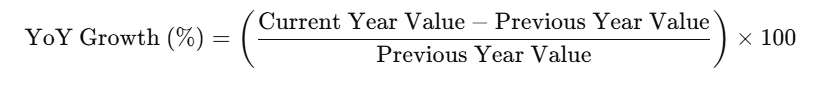

In [28]:
import pandas as pd
import plotly.graph_objects as go

# Ensure datetime format
df_projects['created_at'] = pd.to_datetime(df_projects['created_at'], errors='coerce')

# Extract year and count projects
df_projects['created_year'] = df_projects['created_at'].dt.year
created_year_counts = (
    df_projects['created_year']
    .value_counts()
    .sort_index()
    .reset_index()
)
created_year_counts.columns = ['Year', 'Project Count']

# YoY Growth
created_year_counts['YoY Growth (%)'] = created_year_counts['Project Count'].pct_change().fillna(0) * 100
created_year_counts['YoY Growth (%)'] = created_year_counts['YoY Growth (%)'].round(2)

# Marker color based on growth
created_year_counts['marker_color'] = created_year_counts['YoY Growth (%)'].apply(
    lambda x: 'green' if x >= 0 else 'red'
)

# Hover text
created_year_counts['hover'] = created_year_counts.apply(
    lambda row: f"Year: {row['Year']}<br>Projects: {row['Project Count']}<br>YoY Growth: {row['YoY Growth (%)']}%", axis=1
)

# Plot using plotly.graph_objects
fig = go.Figure()

# Add line trace
fig.add_trace(go.Scatter(
    x=created_year_counts['Year'],
    y=created_year_counts['Project Count'],
    mode='lines',
    line=dict(color='royalblue', width=3),
    name='Project Trend'
))

# Add colored markers
fig.add_trace(go.Scatter(
    x=created_year_counts['Year'],
    y=created_year_counts['Project Count'],
    mode='markers',
    marker=dict(
        size=10,
        color=created_year_counts['marker_color']
    ),
    hovertext=created_year_counts['hover'],
    hoverinfo='text',
    name='Growth Marker'
))

# Annotate peak year
peak_row = created_year_counts.loc[created_year_counts['Project Count'].idxmax()]
fig.add_annotation(
    x=peak_row['Year'],
    y=peak_row['Project Count'],
    text=f"Peak: {peak_row['Project Count']} projects",
    showarrow=True,
    arrowhead=2,
    ax=20,
    ay=-30,
    bgcolor='lightgreen',
    bordercolor='green'
)

# Final layout
fig.update_layout(
    title='Chart 14: Projects Created per Year with YoY Growth Indicators',
    xaxis_title='Year',
    yaxis_title='Project Count',
    xaxis=dict(dtick=1),
    hovermode="x unified"
)

fig.show()


####  Projects Created by Month and Year

In [29]:
import pandas as pd
import plotly.express as px

# Ensure 'created_at' is datetime
df_projects['created_at'] = pd.to_datetime(df_projects['created_at'], errors='coerce')

# Create month-year datetime column
df_projects['month_year'] = df_projects['created_at'].dt.to_period('M').dt.to_timestamp()

# Count projects per month
monthly_counts = df_projects.groupby('month_year').size().reset_index(name='Project Count')

# Create a full monthly timeline from min to max date
full_range = pd.date_range(start=monthly_counts['month_year'].min(),
                           end=monthly_counts['month_year'].max(),
                           freq='MS')  # MS = Month Start

# Create full DataFrame and merge
full_months_df = pd.DataFrame({'month_year': full_range})
full_months_df = full_months_df.merge(monthly_counts, on='month_year', how='left')
full_months_df['Project Count'] = full_months_df['Project Count'].fillna(0).astype(int)

# Add human-readable labels
full_months_df['Month-Year Label'] = full_months_df['month_year'].dt.strftime('%B %Y')

# Add color column
full_months_df['color'] = full_months_df['Project Count'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot line
fig = px.line(
    full_months_df,
    x='Month-Year Label',
    y='Project Count',
    title='Chart 15: Projects Created by Month and Year',
)

# Add colored points
fig.add_scatter(
    x=full_months_df['Month-Year Label'],
    y=full_months_df['Project Count'],
    mode='markers',
    marker=dict(color=full_months_df['color'], size=10),
    name='Project Count Points',
    showlegend=False
)

fig.update_layout(
    xaxis_title='Month-Year',
    yaxis_title='Project Count',
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


#### Projects Created by Day of the Week

In [30]:
df_projects['weekday'] = df_projects['created_at'].dt.day_name()
weekday_counts = df_projects['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()
weekday_counts.columns = ['Day', 'Project Count']

fig = px.bar(
    weekday_counts,
    x='Day',
    y='Project Count',
    color='Day',
    title='Chart 16: <b>Projects Created by Day of the Week</b>',
    text='Project Count'
)
fig.update_layout(xaxis_title='Day', yaxis_title='Number of Projects', title_x=0.5)
fig.show()


### Resource Enrollment Analysis

In [31]:
from collections import Counter
import pandas as pd
import plotly.express as px

# --- Safe parsing ---
df = df_milestone_resource.copy()

# Make sure TotalHour is numeric
df['TotalHour'] = pd.to_numeric(df['TotalHour'], errors='coerce')

# Normalize ResourceList into a list and explode
def to_list(x):
    if pd.isna(x) or x == '':
        return []
    return [r.strip() for r in str(x).split(',') if r.strip()]

df['ResourceList_norm'] = df['ResourceList'].apply(to_list)
df_exploded = df.explode('ResourceList_norm', ignore_index=True)

# Flatten and count resource appearances
resource_series = df_milestone_resource['ResourceList'].dropna().str.split(',')
flat_list = [res.strip() for sublist in resource_series for res in sublist]
resource_counter = Counter(flat_list)

# Top 10
top_10 = pd.DataFrame(resource_counter.most_common(10), columns=['Resource', 'Milestone Count'])

fig1 = px.bar(
    top_10,
    x='Milestone Count',
    y='Resource',
    color='Milestone Count',
    color_continuous_scale='RdYlGn',
    title='Chart 22: <b>Top 10 Most Involved Resources in Milestone</b>',
    text='Milestone Count'
)

# Reverse y-axis so highest budget is on top
fig1.update_yaxes(autorange="reversed")
fig1.update_layout(xaxis_tickangle=45, title_x=0.5)
fig1.show()

# Bottom 10
bottom_10 = pd.DataFrame(sorted(resource_counter.items(), key=lambda x: x[1])[:10],
                         columns=['Resource', 'Milestone Count'])

fig2 = px.bar(
    bottom_10,
    x='Milestone Count',
    y='Resource',
    color='Milestone Count',
    color_continuous_scale='RdYlGn_r',
    title='<b>Bottom 10 Least Involved Resources in Milestone</b>',
    text='Milestone Count'
)
# Reverse y-axis so highest budget is on top
fig2.update_yaxes(autorange="reversed")
fig2.update_layout(xaxis_tickangle=45, title_x=0.5)
fig2.show()


### Milestone Duration Analysis With Projects Name

In [32]:
df_milestone_resource['start_dt'] = pd.to_datetime(df_milestone_resource['start_dt'], errors='coerce')
df_milestone_resource['end_dt'] = pd.to_datetime(df_milestone_resource['end_dt'], errors='coerce')
df_milestone_resource['duration_days'] = (df_milestone_resource['end_dt'] - df_milestone_resource['start_dt']).dt.days

top_longest = df_milestone_resource.sort_values('duration_days', ascending=False).head(10)
fig = px.timeline(top_longest,
                  x_start='start_dt',
                  x_end='end_dt',
                  y='Milestone',
                  title='Chart 23: Long Duration of Milestone',
                  text='duration_days',
                  color_continuous_scale='RdYlGn_r',
                  color='duration_days')
fig.update_yaxes(autorange='reversed')
fig.show(title_x=0.5)



In [33]:
import plotly.express as px

# Sort and get bottom 10 by TotalHour
bottom_effort = df_milestone_resource.sort_values('TotalHour', ascending=True).head(10)

# Create horizontal bar chart
fig = px.bar(
    bottom_effort,
    x='TotalHour',
    y='Milestone',
    color='TotalHour',
    orientation='h',
    color_continuous_scale='RdYlGn',
    title='Chart 25: Bottom 10 Milestones by Lowest Log Hours',
    text='TotalHour',
    hover_data={
        'Project': True,
        'TotalHour': ':.2f',
        'start_dt': '|%Y-%m-%d',
        'end_dt': '|%Y-%m-%d'
    }
)

# Keep lowest at bottom
fig.update_layout(
    yaxis=dict(autorange=True),
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


### Monthly Logged Hours Trend

In [34]:
import pandas as pd
import plotly.graph_objects as go

# Prepare data
df = df_milestone_resource.copy()
df['start_dt'] = pd.to_datetime(df['start_dt'], errors='coerce')
df['MonthYear'] = df['start_dt'].dt.to_period('M').dt.to_timestamp()

monthly_effort = df.groupby('MonthYear')['TotalHour'].sum().reset_index()

# Define colors based on condition
monthly_effort['marker_color'] = monthly_effort['TotalHour'].apply(lambda x: 'red' if x == 0 else 'green')

# Plot line first (neutral color)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_effort['MonthYear'],
    y=monthly_effort['TotalHour'],
    mode='lines',
    name='Total Hours',
    line=dict(color='gray', width=2),
    hoverinfo='skip'
))

# Add colored markers
fig.add_trace(go.Scatter(
    x=monthly_effort['MonthYear'],
    y=monthly_effort['TotalHour'],
    mode='markers+text',
    marker=dict(
        size=10,
        color=monthly_effort['marker_color']
    ),
    # text=monthly_effort['TotalHour'].round(1),
    textposition='top center',
    name='Monthly Total Hours',
    hovertemplate='%{x|%b %Y}<br>Total Hours: %{y:,.2f}<extra></extra>'
))

# Layout
fig.update_layout(
    title='Chart 26: Monthly Logged Hours Trend',
    xaxis_title='Month-Year',
    yaxis_title='Total Hours',
    hovermode='x unified',
    xaxis=dict(tickformat='%b %Y'),
    yaxis_tickformat=','
)

fig.show()


# Section 3 - Analysis Log Hour Against Issue

In [35]:
import pandas as pd
import plotly.express as px

# Count unique users per project and get top 10
user_issue_count = (
    df_log_hour_issue
    .groupby('EBS_project_name')['user_email']
    .count()
    .reset_index(name='issue_count')
    .sort_values('issue_count', ascending=False)
    .head(10)
)

# Plot
fig = px.bar(
    user_issue_count,
    x='issue_count',
    y='EBS_project_name',
    color='issue_count',
    title='Chart 28: Number of Issues by Project Name',
    color_continuous_scale='RdYlGn_r',
    text='issue_count',
    labels={'EBS_project_name': 'Project', 'issue_count': 'Issue Count'}
)

fig.update_traces(textposition='outside')
fig.update_yaxes(autorange="reversed")
fig.update_layout(xaxis_tickangle=45, title_x=0.5)
fig.show()


In [83]:
import pandas as pd
import plotly.express as px

# ---- Parse HH:MM or HH:MM:SS into decimal hours
def time_to_decimal(v):
    if pd.isna(v):
        return None
    if isinstance(v, (int, float)):   # already numeric hours
        return float(v)
    if isinstance(v, str) and ':' in v:
        parts = v.strip().split(':')
        try:
            parts = list(map(int, parts))
            if len(parts) == 2:
                h, m = parts; s = 0
            elif len(parts) == 3:
                h, m, s = parts
            else:
                return None
            return h + m/60 + s/3600
        except ValueError:
            return None
    return None

# Ensure a numeric hours column
df_log_hour_issue = df_log_hour_issue.copy()
df_log_hour_issue['work_hours'] = df_log_hour_issue['work_duration'].apply(time_to_decimal)

# --- Aggregate per project ---
proj_agg = (
    df_log_hour_issue
    .dropna(subset=['EBS_project_name'])
    .groupby('EBS_project_name', as_index=False)
    .agg(
        issue_count     = ('issue_details', lambda s: s.dropna().astype(str).str.strip().ne('').sum()),
        person_count    = ('user_email',    lambda s: s.dropna().nunique()),
        milestone_count = ('Milestone',     lambda s: s.dropna().nunique()),
        total_hours     = ('work_hours',    'sum'),
        ProjectCategory = ('ProjectCategory', lambda s: s.mode().iat[0] if not s.mode().empty else None),
        project_type    = ('type',            lambda s: s.mode().iat[0] if not s.mode().empty else None),
        project_status  = ('status',          lambda s: s.mode().iat[0] if not s.mode().empty else None),
    )
)

# Hours -> days for hover
proj_agg['days'] = proj_agg['total_hours'] / 8.0

# Top 10 by issues (tie-break by hours)
top_n = 10
top_projects = (
    proj_agg
    .sort_values(['issue_count','total_hours'], ascending=False)
    .head(top_n)
    .copy()
)

# Label shows Issues + Hours + People + Milestones
top_projects['label'] = top_projects.apply(
    lambda r: f"I:{int(r['issue_count'])} | H:{r['total_hours']:.1f}h | P:{int(r['person_count'])}",
    axis=1
)

# --- Plot: Total Issues by Project (with hours in hover) ---
fig = px.bar(
    top_projects,
    x='issue_count',
    y='EBS_project_name',
    color='ProjectCategory',                     # or use your custom map
    # color_discrete_map=project_category_color_discrete_map,
    text='label',
    title='Chart: Total Issues by Project (Top 10) + Hours, People & Milestones',
    labels={
        'EBS_project_name': 'Project',
        'issue_count': 'Total Issues',
        'ProjectCategory': 'Project Category',
        'project_type': 'Project Type',
        'project_status': 'Project Status'
    },
    custom_data=['total_hours', 'days', 'person_count', 'milestone_count', 'ProjectCategory', 'project_type', 'project_status']
)

fig.update_traces(
    textposition='outside',
    hovertemplate=(
        "<b>%{y}</b><br>"
        "Total Issues: %{x}<br>"
        "Total Hours: %{customdata[0]:.2f} h<br>"
        "≈ %{customdata[1]:.2f} days (8h/day)<br>"
        "People (unique): %{customdata[2]}<br>"
        "Milestones (unique): %{customdata[3]}<br>"
        "Category: %{customdata[4]}<br>"
        "Project Type: %{customdata[5]}<br>"
        "Project Type: %{customdata[6]}"
        "<extra></extra>"
    )
)
fig.update_yaxes(autorange="reversed")
fig.update_layout(xaxis_tickangle=45, title_x=0.5)

fig.show()


In [93]:
import pandas as pd
import plotly.graph_objects as go
# Optional: ensure interactive renderer (uncomment one that fits your env)
# import plotly.io as pio
# pio.renderers.default = "notebook_connected"  # or "vscode", "browser"

# --- helpers ---
def time_to_decimal(v):
    if pd.isna(v): return None
    if isinstance(v, (int, float)): return float(v)
    if isinstance(v, str) and ':' in v:
        parts = v.strip().split(':')
        try:
            parts = list(map(int, parts))
            if len(parts) == 2: h, m = parts; s = 0
            elif len(parts) == 3: h, m, s = parts
            else: return None
            return h + m/60 + s/3600
        except ValueError:
            return None
    return None

def count_issues(s: pd.Series) -> int:
    return s.dropna().astype(str).str.strip().ne('').sum()

# Reusable hover template (used for initial trace + every frame)
HOVER_TMPL = (
    "<b>%{y}</b><br>"
    "Total Hours: %{x:.2f} h<br>"
    "≈ %{customdata[0]:.2f} days (8h/day)<br>"
    "Total Issues: %{customdata[1]}<br>"
    "People (unique): %{customdata[2]}<br>"
    "Milestones (unique): %{customdata[3]}<br>"
    "Category: %{customdata[4]}<br>"
    "Project Type: %{customdata[5]}"
    "<extra></extra>"
)

# Optional color map per category
# project_category_color_discrete_map = {"Internal": "#1f77b4", "Client": "#2ca02c", ...}

# --- data & aggregate per project ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

proj_agg = (
    df.dropna(subset=['EBS_project_name'])
      .groupby('EBS_project_name', as_index=False)
      .agg(
          total_hours     = ('work_hours', 'sum'),
          issue_count     = ('issue_details', count_issues),
          person_count    = ('user_email', lambda s: s.dropna().nunique()),
          milestone_count = ('Milestone',  lambda s: s.dropna().nunique()),
          ProjectCategory = ('ProjectCategory', lambda s: s.mode().iat[0] if not s.mode().empty else None),
          project_type    = ('type',            lambda s: s.mode().iat[0] if not s.mode().empty else None),
      )
)

# safety fills
proj_agg['total_hours'] = proj_agg['total_hours'].fillna(0.0)
proj_agg['issue_count'] = proj_agg['issue_count'].fillna(0).astype(int)
proj_agg['person_count'] = proj_agg['person_count'].fillna(0).astype(int)
proj_agg['milestone_count'] = proj_agg['milestone_count'].fillna(0).astype(int)

proj_agg['days'] = proj_agg['total_hours'] / 8.0

# --- category list ---
categories = ['All'] + sorted([c for c in proj_agg['ProjectCategory'].dropna().unique()])

# --- top-10 by HOURS within category ---
top_n = 10
def top_df_for_hours(cat):
    d = proj_agg if cat == 'All' else proj_agg[proj_agg['ProjectCategory'] == cat]
    return d.sort_values('total_hours', ascending=False).head(top_n).reset_index(drop=True)

def colors_for(cat, d):
    if 'project_category_color_discrete_map' in globals():
        if cat == 'All':
            return d['ProjectCategory'].map(project_category_color_discrete_map).fillna('#636EFA').tolist()
        return [project_category_color_discrete_map.get(cat, '#636EFA')] * len(d)
    return ['#636EFA'] * len(d)

# --- build figure (single chart) ---
init_cat = 'All'
d0 = top_df_for_hours(init_cat)
c0 = colors_for(init_cat, d0)

fig = go.Figure()

fig.add_bar(
    x=d0['total_hours'],
    y=d0['EBS_project_name'],
    orientation='h',
    marker=dict(color=c0),
    text=[f"H:{h:.1f}h | I:{i} | P:{p} | M:{m}"
          for h,i,p,m in zip(d0['total_hours'], d0['issue_count'], d0['person_count'], d0['milestone_count'])],
    textposition='outside',
    customdata=d0[['days','issue_count','person_count','milestone_count','ProjectCategory','project_type']].values,
    hovertemplate=HOVER_TMPL,
    name="Total Hours"
)

# --- frames: one per category (top-10 by hours) ---
frames = []
for cat in categories:
    d = top_df_for_hours(cat)
    c = colors_for(cat, d)
    frames.append(go.Frame(
        name=cat,
        data=[go.Bar(
            x=d['total_hours'],
            y=d['EBS_project_name'],
            orientation='h',
            marker=dict(color=c),
            text=[f"H:{h:.1f}h | I:{i} | P:{p} | M:{m}"
                  for h,i,p,m in zip(d['total_hours'], d['issue_count'], d['person_count'], d['milestone_count'])],
            textposition='outside',
            customdata=d[['days','issue_count','person_count','milestone_count','ProjectCategory','project_type']].values,
            hovertemplate=HOVER_TMPL,
            name="Total Hours"
        )]
    ))
fig.frames = frames

# --- dropdown ---
fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        x=0.5, y=1.12, xanchor="center", yanchor="top",
        buttons=[
            dict(label=cat, method="animate",
                 args=[[cat], {"mode":"immediate","frame":{"duration":0,"redraw":True},"transition":{"duration":0}}])
            for cat in categories
        ],
        showactive=True
    )],
    title="Top 10 Projects by Total Hours — filter by Project Category",
    title_x=0.5,
    xaxis_title="Total Hours",
    yaxis_title="Project",
    bargap=0.2,
    height=650,
    margin=dict(l=160, r=40, t=80, b=60),
    # ✅ row-wide hover
    hovermode='y unified',
    hoverdistance=-1,   # <- show even when far from the bar
    hoverlabel=dict(namelength=-1)
)

# biggest on top
fig.update_yaxes(autorange="reversed")

fig.show()


In [56]:
import pandas as pd
import plotly.express as px

# --- helpers ---
def uniq_join(series, limit=8):
    """unique, sorted, joined; trimmed with +N more if long"""
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return "<br> ".join(vals)
    return "<br> ".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# ✅ Step 0: Your time-to-decimal function (unchanged)
def time_to_decimal(time_str):
    if isinstance(time_str, str) and ':' in time_str:
        parts = time_str.strip().split(':')
        try:
            parts = list(map(int, parts))
            if len(parts) == 2:
                hours, minutes = parts; seconds = 0
            elif len(parts) == 3:
                hours, minutes, seconds = parts
            else:
                return None
            return hours + minutes/60 + seconds/3600
        except ValueError:
            return None
    return None

# ✅ Step 1: Apply conversion to new column
df_log_hour_issue['work_hours'] = df_log_hour_issue['work_duration'].apply(time_to_decimal)

# ✅ Step 2: Group by user and calculate sums + unique counts/lists
agg_df = (
    df_log_hour_issue
    .groupby('user_email', as_index=False)
    .agg(
        total_hours=('work_hours', 'sum'),
        log_count=('work_hours', 'count'),
        # NEW: unique counts
        project_count=('EBS_project_name', lambda x: x.dropna().nunique()),
        milestone_count=('Milestone', lambda x: x.dropna().nunique()),
        # Existing extras
        team_names=('team_name', lambda x: ', '.join(sorted(set(x.dropna())))),
        resources=('Resource', lambda x: ', '.join(sorted(set(x.dropna())))),
        # Previews for hover (unique, trimmed)
        project_list=('EBS_project_name', lambda x: uniq_join(x, limit=8)),
        milestone_list=('Milestone', lambda x: uniq_join(x, limit=8)),
    )
)

# ✅ Step 3: Top users by hours
top_users = agg_df.sort_values('total_hours', ascending=False).head(20).copy()

# ✅ Step 4: Plot
fig = px.bar(
    top_users,
    x='user_email',
    y='total_hours',
    text='total_hours',
    color='total_hours',
    color_continuous_scale='RdYlGn',
    title='Chart 21: Top 20 Contributors by Logged Hours',
    labels={'user_email': 'User Email', 'total_hours': 'Total Hours'},
    # pass everything we want to the hover
    custom_data=[
        'log_count',
        'project_count', 'milestone_count',
        'project_list', 'milestone_list',
        'team_names', 'resources'
    ]
)

# ✅ Step 5: Format hover (now includes unique counts + previews)
fig.update_traces(
    texttemplate='%{text:.2f} h',
    hovertemplate=(
        '<b>User</b>: %{x}<br>'
        '<b>Total Hours</b>: %{y:.2f}<br>'
        '<b>Log Count</b>: %{customdata[0]}<br>'
        '<b>Teams</b>: %{customdata[5]}<br>'
        '<b>Resources</b>: %{customdata[6]}<br>'
        '<b>Number of Projects</b>: %{customdata[1]}<br>'
        '<b>Number of Milestones</b>: %{customdata[2]}<br>'
        '<b>Projects</b>:<br> %{customdata[3]}<br>'
        '<b>Milestones</b>:<br> %{customdata[4]}<br>'
        '<extra></extra>'
    )
)

fig.update_layout(
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


In [70]:
import pandas as pd
import plotly.graph_objects as go

# --- helper to make short unique previews for table cells ---
def uniq_join(series, limit=8):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return ", ".join(vals)
    return ", ".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# --- time_to_decimal + work_hours (reuse your function) ---
def time_to_decimal(time_str):
    if isinstance(time_str, str) and ':' in time_str:
        parts = time_str.strip().split(':')
        try:
            parts = list(map(int, parts))
            if len(parts) == 2:
                hours, minutes = parts; seconds = 0
            elif len(parts) == 3:
                hours, minutes, seconds = parts
            else:
                return None
            return hours + minutes/60 + seconds/3600
        except ValueError:
            return None
    return None

df_log_hour_issue['work_hours'] = df_log_hour_issue['work_duration'].apply(time_to_decimal)

# --- aggregate per user (unique projects & milestones) ---
agg_df = (
    df_log_hour_issue
    .groupby('user_email', as_index=False)
    .agg(
        total_hours=('work_hours', 'sum'),
        log_count=('work_hours', 'count'),
        project_count=('EBS_project_name', lambda x: x.dropna().nunique()),
        milestone_count=('Milestone', lambda x: x.dropna().nunique()),
        project_preview=('EBS_project_name', lambda x: uniq_join(x, limit=8)),
        milestone_preview=('Milestone', lambda x: uniq_join(x, limit=8)),
        team_names=('team_name', lambda x: ', '.join(sorted(set(x.dropna())))),
        resources=('Resource', lambda x: ', '.join(sorted(set(x.dropna())))),
    )
)

# --- add days (8h/day), round, order columns ---
table_df = agg_df.copy()
table_df['days'] = (table_df['total_hours'] / 8).round(2)
table_df['total_hours'] = table_df['total_hours'].round(2)

cols = [
    'user_email', 'total_hours', 'days', 'log_count',
    'project_count', 'milestone_count',
    # 'project_preview', 'milestone_preview',
    'team_names', 'resources'
]

table_df = (
    table_df[cols]
    .sort_values(['total_hours', 'project_count', 'milestone_count'], ascending=False)
    .reset_index(drop=True)
)

# --- OPTIONAL: limit to top N rows (set to None for all) ---
top_n = 20  # e.g., 50
if top_n:
    table_df = table_df.head(top_n)

# --- Plotly table ---
header_vals = [
    "User Email", "Total Hours", "Days (8h/day)", "Log Count",
    "Projects", "Milestones",
    # "Projects (preview)", "Milestones (preview)",
    "Teams", "Resources"
]

# Column width (✅ fixed)
column_widths = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15]

table_fig = go.Figure(data=[go.Table( columnwidth=column_widths,
    header=dict(values=header_vals,
                  fill_color='burlywood',
                  align='center',
                  font=dict(size=15),
                  height=40,
                  line_color='black',
                  line_width=2),
    cells=dict(values=[table_df[c] for c in cols],
                 fill_color='white',
                align='center',
                font=dict(size=15),
                height=35,
                line_color='black',
                line_width=2)
)])
table_fig.update_layout(
    title=dict(
        text="<b>Top 20 Contributors by Logged Hours</b><br>Since July 2023 to August 2025",
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    margin=dict(t=100, b=40),
    height=1000
)
table_fig.show()


